# Working with unlabeled data - Clustering analysis

**Clustering analysis** is a category of **unsupervised learning** that allows us to discover hidden structures in data. 

## Grouping objects with k-means

One of the most popular clustering algorithms is **k-means** which is very efficient and is good for finding sferic shapes in data. One of the major drawbacks is that we have to feed it a priori with the **k**, the number of clusters.

In [1]:
from sklearn.datasets import make_blobs

In [2]:
x, y = make_blobs(n_samples=150,
                  n_features=2,
                  centers=3,
                  cluster_std=.5,
                  shuffle=True,
                  random_state=0)

In [3]:
import matplotlib.pyplot as plt

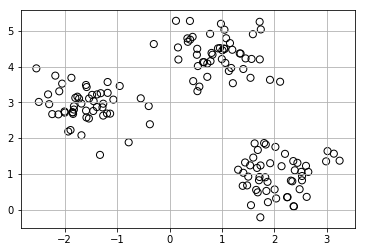

In [4]:
plt.scatter(x[:, 0],
            x[:, 1],
            edgecolors='black',
            facecolors='none',
            marker='o',
            s=50)
plt.grid()
plt.show()

In reality we don't know any category information about samples, so our goal is to group them according to their feature similarities. We can do this by using k-means, the algorithm can be summarized as:

1. Randomly pick $k$ centroids from the sample points as initial cluster centers
2. Assign each sample to the nearest centroid $\mu^{(j)}$
3. Move the centroids to the center of the samples that were assigned to it
4. Repeat steps 2 and 3 until the cluster assignments do not change

But how do we measure similarity? We can define *similarity* as the opposite of distance, and a commonly used distance is the **squared Euclidean distance**:

$$
d(x,y)^2=\sum_{j=1}^{m}(x_j-y_j)^2=||x-y||_{2}^{2}
$$

In this case $j$ refers to the jth dimension of the sample points, we will use $i$ and $j$ to indicate sample index and cluster index, respectively.

Based on the previously defined distance now we have an optimization problem.

In [5]:
from sklearn.cluster import KMeans

In [6]:
km = KMeans(n_clusters=3,
            init='random',
            n_init=10,
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(x)

In the code above we set the number of clusters to 3 (*n_clusters=3*), then we set *n_init=10* to run the algo 10 times independently with different random centroids and choose the one with the lowest SSE. The [**KMeans**](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) implementation stops early if it reaches convergence. We can control the tolerance of the changes in the SSE with *tol* argument, which in this case we set equal to 0.0001, the larger the tolerance the earlier the convergence.

### K-means++

One of the issues with choosing random centroids is that we have to run multiple k-means at the same time to ensure convergence and/or a good result. Another way to deal with this issue is to place the initial centroids far away from each other, this approach is called **k-means++** and we can use it by simply passing it to the *init* parameter of **KMeans** (which is actually the default)

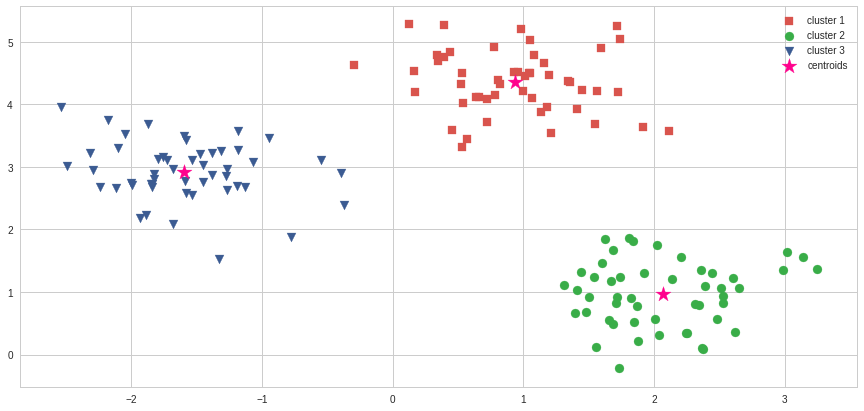

In [7]:
import seaborn as sns
sns.set(style='whitegrid', context='notebook', rc={"figure.figsize": (15, 7)})

plt.scatter(x[y_km == 0, 0],
            x[y_km == 0, 1],
            s=80,
            c=sns.xkcd_rgb["pale red"],
            marker='s',
            label='cluster 1')
plt.scatter(x[y_km == 1, 0],
            x[y_km == 1, 1],
            s=80,
            c=sns.xkcd_rgb["medium green"],
            marker='o',
            label='cluster 2')
plt.scatter(x[y_km == 2, 0],
            x[y_km == 2, 1],
            s=80,
            c=sns.xkcd_rgb["denim blue"],
            marker='v',
            label='cluster 3')
plt.scatter(km.cluster_centers_[:, 0],
            km.cluster_centers_[:, 1],
            s=250,
            c=sns.xkcd_rgb["hot pink"],
            marker='*',
            label='centroids')
plt.legend()
plt.show()

### Hard vs soft clustering

**Hard clustering** describes algos that assign each sample of a dataset to one cluster - for instance k-means - while **soft clustering** (or **fuzzy clustering**) assign a sample to one or more clusters. A popular example is **fuzzy C-means (FCM)**.

**FCM** procedure is very similar to k-means, but instead of getting an assignemnt we get probabilities for each point belonging to each cluster. Unfortunately FCm is not implemented in scikit-learn, however in practice it has been proven that k-means and FCM produce very similar results.

### Elbow method for k

Since in unsupervised learning we can't check whether the clusters are "correct" we have to use intrinsic metrics, in this case we will use the within-cluster SSE, which is accessible via the **inertia\_** attribute in a fitted **KMeans** object

In [8]:
print('Distortion: %.2f' % km.inertia_)

Distortion: 72.48


The **elbow method** is a visual way to identify an optimal value for k

In [9]:
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i,
                init='k-means++',
                n_init=10,
                max_iter=300,
                random_state=0)
    km.fit(x)
    distortions.append(km.inertia_)

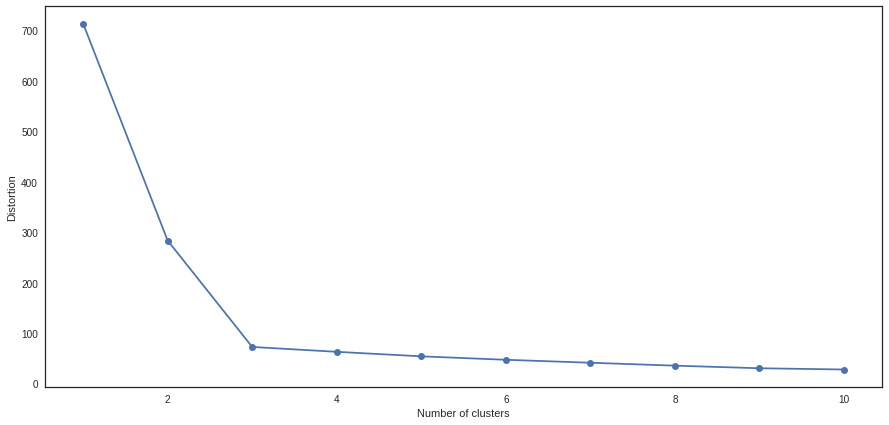

In [10]:
sns.set(style='white', context='notebook', rc={"figure.figsize": (15, 7)})
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

As we can see, the elbow is located at *k=3*, which is a good choice for this dataset.

### Clustering quality via silhouette plots

The **silhouette coefficient** is bounded in the range -1 to 1, and it is available as [**silhouette_samples**](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_samples.html) in the **metrics** modules.

In [11]:
km = KMeans(n_clusters=3,
            init='k-means++',
            n_init=10,
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(x)

In [12]:
import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples

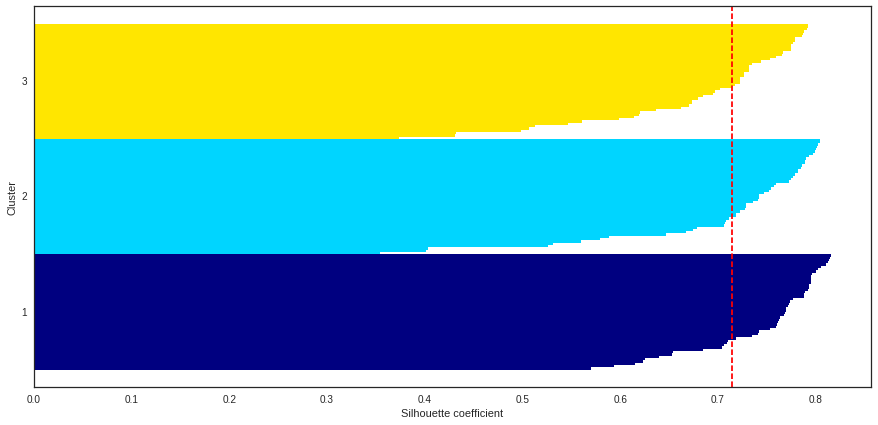

In [13]:
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(x, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(i / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals,
             height=1.0, edgecolor='none', color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals)

silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg,
            color='red',
            linestyle='--')
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.show()